# Previsão de Terremotos

Nesta competição, você irá dizer quando o terremoto ocorrerá. Especificamente, você ira predizer o tempo restante antes que os terremotos de laboratório ocorram em dados sísmicos em tempo real.

As submissões são avaliadas usando o erro absoluto médio entre o tempo previsto restante antes do próximo terremoto do laboratório e o tempo restante real.

seg_id, time_to_failure

seg_00030f, 0

seg_0012b5, 0

seg_00184e, 0

![alt text](https://wol-prod-cdn.literatumonline.com/cms/attachment/ce383c18-1ce9-48b0-994f-e090415d1e51/grl51070-fig-0001-m.jpg)

[![Everything Is AWESOME](http://s2.glbimg.com/tIZyJyit3HLDTkZMSbHKcM5ncCw=/0x0:695x489/695x489/s.glbimg.com/po/tt2/f/original/2016/01/22/youtube-logo.jpg)](https://www.youtube.com/embed/m_dBwwDJ4uo?t=194 "Everything Is AWESOME")



# Explorar os dados 

In [2]:
import pandas as pd
import numpy as np

In [3]:
!ls

LANL-Earthquake-Prediction	sample_submission.csv  test	 train.csv
LANL-Earthquake-Prediction.zip	Seismology.ipynb       test.zip


In [4]:
#Pegar os dados de treinamento
trainh = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [5]:
#Ver os dados
trainh.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


In [6]:
import matplotlib.pyplot as plt

In [7]:
#visualizar 1% dos dados - primeiros 100 pontos

train_acoustic = trainh['acoustic_data'].values
train_time = trainh['time_to_failure'].values

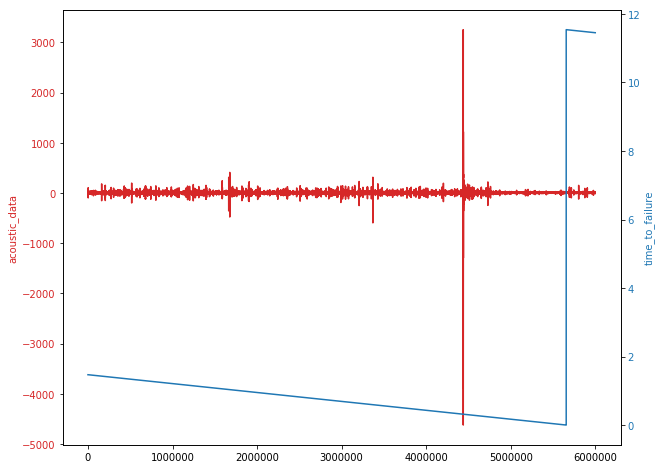

In [17]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_ylabel('acoustic_data', color=color)
ax1.plot(train_acoustic, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('time_to_failure', color=color) 
ax2.plot(train_time, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.rcParams['figure.figsize'] = [10, 10]

# Criação de Características

In [18]:
def gen_features(X): 
  strain = []
  strain.append(X.mean())
  strain.append(X.std())
  strain.append(X.min())
  strain.append(X.kurtosis())
  strain.append(X.skew())
  strain.append(np.quantile(X,0.01))
  strain.append(np.quantile(X,0.05))
  strain.append(np.quantile(X,0.95))
  strain.append(np.quantile(X,0.99))
  strain.append(np.abs(X).max())
  strain.append(np.abs(X).mean())
  strain.append(np.abs(X).std())
  return pd.Series(strain)

![alt text](https://qph.fs.quoracdn.net/main-qimg-29a4925034e075f16e1c743a4b3dda8b)
![alt text](https://qph.fs.quoracdn.net/main-qimg-cb5a6703bdfd5e2a15cf8865607a1590)
![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTkRGxxt76XIth4pjG5Itp-k6MNt5qPaejI_gyENu17KkGC2oFq)
![alt text](https://cramster-image.s3.amazonaws.com/definitions/DC-2195V1.png)
![alt text](https://i.stack.imgur.com/KBQLN.jpg)
- Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. 
- Data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers
![alt text](https://study.com/cimages/multimages/16/skewness_posnegpict.jpg)
- skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. The skewness value can be positive or negative, or undefined.
![alt text](https://upload.wikimedia.org/wikipedia/commons/5/5e/Iqr_with_quantile.png)
- Quantiles are cut points dividing the range of a probability distribution into continuous intervals with equal probabilities, or dividing the observations in a sample in the same way. 


![alt text](https://www.researchgate.net/publication/304403489/figure/fig4/AS:427142036103170@1478850005427/Statistical-features.png
)

# Estimativa pela rede neural

In [19]:
train = pd.read_csv('train.csv', iterator = True, chunksize =150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()

for df in train:
  ch = gen_features(df['acoustic_data'])
  X_train = X_train.append(ch, ignore_index=True)
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [20]:
from sklearn.metrics import mean_absolute_error

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [21]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

In [22]:
X_tr = X_train[:18000]
X_val = X_train[18000:]
y_tr = y_train[:18000]
y_val = y_train[18000:]


![alt text](https://cdn-images-1.medium.com/max/1600/1*dnvGC-PORSoCo7VXT3PV_A.png)

In [23]:
def criar_rede():
    regressor = Sequential()
    # Primeira Camada Escondida
    regressor.add(Dense(units = 128, activation = 'relu', input_dim =X_train.shape[1])) 
    regressor.add(Dropout(0.25))
    #Segunda Camada Escondida
    regressor.add(Dense(units = 64, activation = 'relu')) 
    #Terceira Camada Escondida
    regressor.add(Dense(units = 32, activation = 'relu')) 
    #Camada de Saída
    regressor.add(Dense(units = 1, activation = 'linear'))
    regressor.compile(loss = 'mean_absolute_error', optimizer = 'adam',
                   metrics = ['mean_absolute_error'])
    return regressor

In [92]:
regressor = KerasRegressor(build_fn = criar_rede)
resultado = regressor.fit(X_tr, y_tr, validation_data=(X_val,y_val), 
                          epochs =1000,  batch_size = 32)

Train on 4195 samples, validate on 0 samples
Epoch 1/1000
4195/4195 [==============================] - 0s 75us/step - loss: 2.9835 - mean_absolute_error: 2.9835
Epoch 2/1000
4195/4195 [==============================] - 0s 24us/step - loss: 2.2173 - mean_absolute_error: 2.2173
Epoch 3/1000
4195/4195 [==============================] - 0s 25us/step - loss: 2.1740 - mean_absolute_error: 2.1740
Epoch 4/1000
4195/4195 [==============================] - 0s 24us/step - loss: 2.1487 - mean_absolute_error: 2.1487
Epoch 5/1000
4195/4195 [==============================] - 0s 25us/step - loss: 2.1349 - mean_absolute_error: 2.1349
Epoch 6/1000
4195/4195 [==============================] - 0s 24us/step - loss: 2.1453 - mean_absolute_error: 2.1453
Epoch 7/1000
4195/4195 [==============================] - 0s 26us/step - loss: 2.1282 - mean_absolute_error: 2.1282
Epoch 8/1000
4195/4195 [==============================] - 0s 25us/step - loss: 2.1279 - mean_absolute_error: 2.1279
Epoch 9/1000
4195/4195 [===

In [93]:
# list all data in history
print(resultado.history.keys())

dict_keys(['loss', 'mean_absolute_error'])


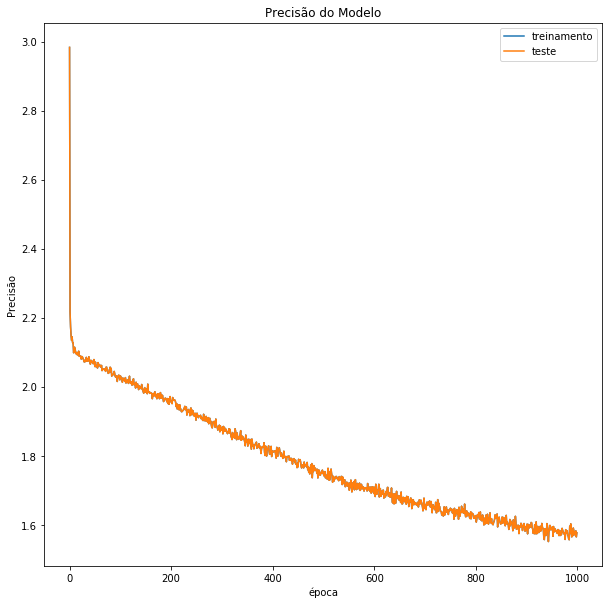

In [94]:
plt.plot(resultado.history['loss'])
plt.plot(resultado.history['mean_absolute_error'])
plt.title('Precisão do Modelo')
plt.ylabel('Precisão')
plt.xlabel('época')
plt.legend(['treinamento', 'teste'], loc='upper right')
plt.show()

In [95]:
y_predict= regressor.predict(X_tr)

In [96]:
y_predict.shape

(4195,)

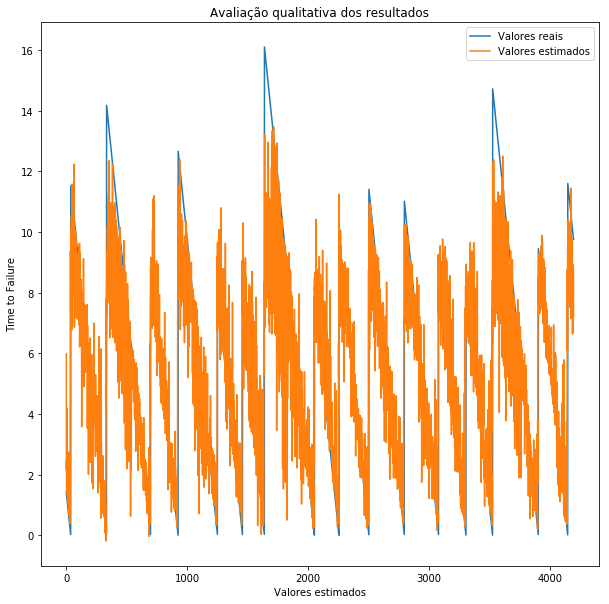

In [97]:

plt.plot(np.linspace(1,4195,4195),y_tr[0:4195])
plt.plot(np.linspace(1,4195,4195),y_predict[0:4195])
plt.title('Avaliação qualitativa dos resultados')
plt.ylabel('Time to Failure')
plt.xlabel('Valores estimados')
plt.legend(['Valores reais', 'Valores estimados'], loc='upper right')
plt.show()

# Submissão

In [98]:
#submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame()
submission = pd.DataFrame(columns=['seg_id'])
i=1
import glob
path = '/home/allan/Documentos/notebooks/terremoto/test/*.csv'
files = glob.glob(path)
for seg_id in files:
    seg = pd.read_csv(seg_id)
    ch = gen_features(seg['acoustic_data'])
    X_test = X_test.append(ch, ignore_index=True)
    seg_id2 = seg_id.replace('/home/allan/Documentos/notebooks/terremoto/test/','')
    seg_id3 = seg_id2.replace('.csv','')
    submission.loc[i] = seg_id3
    i = i +1
X_test = sc.transform(X_test)

In [99]:
predicts = regressor.predict(X_test)

In [100]:
submission['time_to_failure'] = predicts
submission.to_csv('submission.csv',index=False)

In [90]:
submission.head()

,seg_id,time_to_failure
1,seg_2d3828,4.289023
2,seg_d39131,8.889006
3,seg_6f650f,7.960383
4,seg_d36737,2.789725
5,seg_0e7cc5,5.431671


# Créditos

Este notebook foi baseado neste vídeo e notebooks.
This notebook was based in this video and notebooks.

https://www.youtube.com/watch?v=TffGdSsWKlA

https://github.com/llSourcell/Kaggle_Earthquake_challenge

https://www.kaggle.com/kaggle2shmaggle/earthquake-ffnn-in-keras




